In [79]:
import pickle
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm 
from numba import njit, prange

from scipy.sparse import csr_matrix
from collections import defaultdict
from numpy.linalg import inv
from numpy.linalg import cond, matrix_rank
from scipy.sparse import lil_matrix 

## Aggregation of Final Matrix and Symmetry
There are some adjustments to the final matrix that we perform to make it ready for clustering. Symmetry is applied by sub-matrix for speed purposes.

### Open filepath

In [80]:
# Open the h5 file 
worm = 'sub-20190929-06'
filepath = '/scratch/nar8991/computer_vision'

# TO DO - Maybe add logic so it can just take the file from above rather than opening the .h5 file again

In [81]:
# Function to recursively load data from an HDF5 file into a Python dictionary
def load_dict_from_h5(file_name):
    data = {}
    
    # Open the HDF5 file
    with h5py.File(file_name, 'r') as f:
        # Recursively extract the groups and datasets into a dictionary
        def read_group(group, data_dict):
            for key, value in group.items():
                if isinstance(value, h5py.Group):
                    # If it's a group (nested dictionary), recursively read it
                    data_dict[key] = {}
                    read_group(value, data_dict[key])
                else:
                    # If it's a dataset, store it in the dictionary
                    data_dict[key] = value[()]
        
        # Start reading the file from the root group
        read_group(f, data)
    
    return data

# Load the HDF5 file into a variable
label_matrix = load_dict_from_h5(f'{filepath}/{worm}_fast_similarity_matrix.h5')

### Functions for symmetry, clustering, and reading in files

The label map is used for initial index numbering, which is used for the clustering code.

In [82]:
def enforce_symmetry(M, intended_length):
    # Get the number of rows and columns
    rows, cols = M.shape
    # print(rows, cols)
    # If the matrix is not square, pad it with zeros to make it square
    if rows != intended_length or cols != intended_length:
        padded_matrix = np.zeros((intended_length, intended_length))
        padded_matrix[:rows, :cols] = M  # Copy the original matrix into the top-left corner
        M = padded_matrix  # Now M is square
    
    n = intended_length# Now M is guaranteed to be square
    # print(n)
    # Iterate over the upper triangular part of the matrix (excluding the diagonal)
    for i in range(n):
        for j in range(i + 1, n):
            if M[j, i] == 0 and M[i, j] != 0:
                M[j, i] = M[i, j]  # Copy value from upper to lower triangle
            elif M[j, i] != 0 and M[i, j] == 0:
                M[i, j] = M[j, i]  # Copy value from lower to upper triangle
    return M

def create_label_map(centroids=40, timepoints=5):
    label_map = {}
    # Identify timestamps that are non-zero - THIS IS NOT NEEDED FOR OUR ATANAS/EY CODE
    for timestamp in range(0, timepoints):
        label_map[timestamp] = {}
        # Add only the centroids that are in the matrix - THIS IS NEEDED FOR OUR ATANAS/EY CODE
        for j in range(0, centroids):
            label_map[timestamp][j] = j
    return label_map

def create_final_matrix(label_dict, centroids=400):
    max_t = 0
    max_fixed_t = 0
    min_non_zero = 1
    max_non_zero = 0
    sum = 0
    total_count = 0
    for key, value in label_dict.items():
        start = int(key.split('to')[0])
        end = int(key.split('to')[1])
        non_zero_arr = value[np.nonzero(value)]
        max_value = np.max(non_zero_arr)
        min_value = np.min(non_zero_arr)
        min_non_zero = min(min_value, min_non_zero)
        max_non_zero = max(max_value, max_non_zero)
        sum += np.sum(non_zero_arr)
        total_count += non_zero_arr.size
        max_t = max(end, max_t)
        max_fixed_t = max(start, max_fixed_t)
    print(min_non_zero)
    print(max_non_zero)
    print(sum/total_count)
    dim = (max_t + 1) * centroids  # Assume we start at 0
    print(f"Matrix dimension: {dim}")
    
    # Create a sparse matrix in LIL (List of Lists) format for efficient row-based operations
    final_matrix = lil_matrix((dim, dim))
    
    label_map = {}
    
    for key, value in label_dict.items():
        start = int(key.split('to')[0])
        end = int(key.split('to')[1])
        start_length = value.shape[1]
        end_length = value.shape[0]        
        
        if start not in label_map:
            label_map[start] = {}
        if start_length-1 not in label_map[start]:
            for i in range(start_length):
                label_map[start][i] = i
        if end not in label_map:
            label_map[end] = {}
        if end_length-1 not in label_map[end]:
            for i in range(end_length):
                label_map[end][i] = i
        start_val = start * centroids
        end_val = end * centroids
        
        # Set values in the sparse matrix (enforce symmetry if needed)
        final_matrix[end_val:end_val+centroids, start_val:start_val+centroids] = -enforce_symmetry(value, centroids)
        
    return final_matrix, label_map

In [83]:
final_matrix, label_map = create_final_matrix(label_matrix)

0.0007535795026375283
0.9451219512195121
0.043926886872868026
Matrix dimension: 384800


## Clustering (Nalini and Maren)

We integrated the sparse implementation of hierarchical minimum linkage clustering outlined in the ANTSUN pipeline, converted from Python to Julia. The major change is that we get modify the overlapping timestamp logic to reflect our new data structure.

We also adjust the height threshold based on our new data distribution (as well as the fact that we only use IoU and do not apply heuristics)

### SparseClustering.jl functions

Recreation of sparse clustering in Python based on code from https://github.com/flavell-lab/SparseClustering.jl

In [84]:
#https://github.com/flavell-lab/SparseClustering.jl/blob/main/src/unionfind.jl

class UnionFind:
    def __init__(self, n):
        """
        Initializes a UnionFind data structure for n elements.

        Args:
        - n (int): The number of elements.
        """
        self.parent = list(range(n))  # Parent array: Each element points to itself initially.
        self.rank = [0] * n  # Rank array: Initialize ranks to 0.

    def find(self, x):
        """
        Finds the representative (root) of the subset containing x with path compression.

        Args:
        - x (int): The element whose representative we want to find.

        Returns:
        - int: The representative (root) of the subset containing x.
        """
        if self.parent[x] != x:
            # Path compression: flatten the structure by pointing directly to the root.
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        """
        Merges the subsets containing x and y using union by rank.

        Args:
        - x (int): The first element to merge.
        - y (int): The second element to merge.
        """
        rootX = self.find(x)
        rootY = self.find(y)

        if rootX != rootY:
            # Union by rank: Attach the smaller tree to the root of the larger tree
            if self.rank[rootX] > self.rank[rootY]:
                self.parent[rootY] = rootX
            elif self.rank[rootX] < self.rank[rootY]:
                self.parent[rootX] = rootY
            else:
                # If both have the same rank, attach rootY to rootX and increase rank of rootX
                self.parent[rootY] = rootX
                self.rank[rootX] += 1


In [85]:
#https://github.com/flavell-lab/SparseClustering.jl/blob/main/src/unionfind.jl

class UnionFindAdj:
    def __init__(self, n):
        """
        Initializes a UnionFind data structure for n elements.

        Args:
        - n (int): The number of elements.
        """
        self.parent = list(range(n))  # Parent array: Each element points to itself initially.
        self.rank = [0] * n  # Rank array: Initialize ranks to 0.

    def find(self, x):
        """
        Finds the representative (root) of the subset containing x with path compression.

        Args:
        - x (int): The element whose representative we want to find.

        Returns:
        - int: The representative (root) of the subset containing x.
        """
        if self.parent[x] != x:
            # Path compression: flatten the structure by pointing directly to the root.
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y,x_ts, y_ts):
        """
        Merges the subsets containing x and y using union by rank.

        Args:
        - x (int): The first element to merge.
        - y (int): The second element to merge.
        """
        rootX = self.find(x)
        rootY = self.find(y)

        new_ts = set(y_ts).union(set(x_ts))        
        
        if rootX != rootY:
            # Union by rank: Attach the smaller tree to the root of the larger tree
            if self.rank[rootX] > self.rank[rootY]:
                self.parent[rootY] = rootX
            elif self.rank[rootX] < self.rank[rootY]:
                self.parent[rootX] = rootY
            else:
                # If both have the same rank, attach rootY to rootX and increase rank of rootX
                self.parent[rootY] = rootX
                self.rank[rootX] += 1
        return new_ts
 
        


In [86]:
# https://github.com/flavell-lab/SparseClustering.jl/blob/main/src/util.jl

def sort_distance_matrix(s):
    """
    Sort the non-zero entries of the upper triangular part of a sparse distance matrix
    and return the (i, j) indices of these entries sorted by their values.
    
    Arguments:
    - s (scipy.sparse.csr_matrix): A sparse matrix, typically representing a distance matrix.
    
    Returns:
    - List of tuples: A list of (i, j) index tuples sorted by the distance values.
    """
    coo = s.tocoo()
    pairs = []
    for i, j, value in zip(coo.row, coo.col, coo.data):
        if i < j:  # Only consider the upper triangular part (excluding the diagonal)
            pairs.append((i, j, value))
    
    pairs.sort(key=lambda x: x[2])
    return [(i, j) for i, j, _ in pairs]


def generate_timepoint_map(inv_map, n, max_timept):
    """
    Generate a matrix representing time points where each ROI was detected.
    
    Arguments:
    - inv_map (dict): A dictionary where each key is an ROI, and each value is a set of time points where the ROI was found.
    - n (int): Number of ROIs.
    - max_timept (int): The maximum number of time points in the dataset.
    
    Returns:
    - numpy.ndarray: A matrix of size n x max_timept. The entry (i, j) is 1 if the i-th ROI was detected at time point j, 0 otherwise.
    """
    # I added another point because "max timept" is not actually max timept
    timepoint_map = np.zeros((n, max_timept), dtype=int)
    
    for roi, timepoints in inv_map.items():
        for t in timepoints:
            timepoint_map[roi, t] = 1
    
    return timepoint_map


No timestep-merge clustering which was not effective and thus not used, but we included the accompanying code given related visualizations.

In [87]:
# https://github.com/flavell-lab/SparseClustering.jl/blob/main/src/hclust.jl

def hclust_minimum_threshold_sparse(ds, inv_map, overlap_threshold, height_threshold, use_sparse=True, pair_match=False):
    """
    Perform hierarchical clustering on a pairwise distance matrix with additional constraints:
    - Avoid merging clusters that would cause ROIs from the same time point to be clustered together.
    - Stop clustering when the distance exceeds the height threshold.
    
    Arguments:
    - ds (numpy.ndarray or scipy.sparse matrix): Matrix of pairwise distances between ROIs.
    - inv_map (dict): Mapping from ROIs to time points.
    - overlap_threshold (float): Threshold for ROI overlap in clusters (0 to 1).
    - height_threshold (float): Maximum distance for merging ROIs.
    - use_sparse (bool): Whether to use sparse matrices for the distance matrix.
    - pair_match (bool): Whether to restrict merges to pairs of size at most 2.
    
    Returns:
    - UnionFind: A UnionFind object representing the current clusters.
    """
    # Convert to sparse if needed
    if use_sparse:
        d = ds.tocsr()
    else:
        d = np.array(ds)

    n = d.shape[0]
    
    # Sort the distance matrix (upper triangle)
    sorted_pairs_list = sort_distance_matrix(d)
    
    # Generate timepoint map
    max_frame = max(max(y for y in timepoints) for timepoints in inv_map.values()) + 1

    ROI_num = int(n / max_frame)
    # print(ROI_num)
    
    timepoint_map = generate_timepoint_map(inv_map, ROI_num, max_frame)

    # Initialize UnionFind for clustering
    curr_cluster_ids = UnionFind(n)

    # Initialize merged nodes tracking if pair_match is True
    if pair_match:
        merged_nodes = [False] * n
    
    new_tree_frame = np.zeros_like(timepoint_map[1, :], dtype=int)

    # print(sorted_pairs_list)
    for i, j in sorted_pairs_list:
        # If the distance is too high, stop clustering
        # print(d[i,j])
        if d[i, j] > height_threshold:
            break
        # print("Passed height threshold")

        clust_i = curr_cluster_ids.find(i)
        clust_j = curr_cluster_ids.find(j)
        # print(clust_i)
        # print(clust_j)

        # Skip if they are already in the same cluster or already merged if pair_match
        if clust_i == clust_j or (pair_match and (merged_nodes[i] or merged_nodes[j])):
            continue
        i_timestamp = clust_i // ROI_num
        j_timestamp = clust_j // ROI_num

        # # This is only if the centroids 
        # if i_timestamp == j_timestamp:
        #     continue

        curr_cluster_ids.union(clust_i, clust_j)
        
        overlaps = np.sum(new_tree_frame > 1)

        # If pair_match is True, mark the nodes as merged
        if pair_match:
            merged_nodes[i] = True
            merged_nodes[j] = True

    return curr_cluster_ids

In [88]:
# https://github.com/flavell-lab/SparseClustering.jl/blob/main/src/hclust.jl

def hclust_minimum_threshold_sparse_no_timestep(ds, inv_map, overlap_threshold, height_threshold, use_sparse=True, pair_match=False):
    """
    Perform hierarchical clustering on a pairwise distance matrix with additional constraints:
    - Avoid merging clusters that would cause ROIs from the same time point to be clustered together.
    - Stop clustering when the distance exceeds the height threshold.
    
    Arguments:
    - ds (numpy.ndarray or scipy.sparse matrix): Matrix of pairwise distances between ROIs.
    - inv_map (dict): Mapping from ROIs to time points.
    - overlap_threshold (float): Threshold for ROI overlap in clusters (0 to 1).
    - height_threshold (float): Maximum distance for merging ROIs.
    - use_sparse (bool): Whether to use sparse matrices for the distance matrix.
    - pair_match (bool): Whether to restrict merges to pairs of size at most 2.
    
    Returns:
    - UnionFind: A UnionFind object representing the current clusters.
    """
    # Convert to sparse if needed
    if use_sparse:
        d = ds.tocsr()
    else:
        d = np.array(ds)

    n = d.shape[0]
    
    # Sort the distance matrix (upper triangle)
    sorted_pairs_list = sort_distance_matrix(d)
    
    # Generate timepoint map
    max_frame = max(max(y for y in timepoints) for timepoints in inv_map.values()) + 1
    ROI_num = int(n / max_frame)

    # print(ROI_num)
    
    timepoint_map = generate_timepoint_map(inv_map, ROI_num, max_frame)

    # Initialize UnionFind for clustering
    curr_cluster_ids = UnionFindAdj(n)

    # Initialize merged nodes tracking if pair_match is True
    if pair_match:
        merged_nodes = [False] * n
    
    new_tree_frame = np.zeros_like(timepoint_map[1, :], dtype=int)

    timesteps_per_cluster=[]
    for i in np.arange(n):
        timesteps_per_cluster.append([i//ROI_num])

    # print(sorted_pairs_list)
    for i, j in sorted_pairs_list:
        # If the distance is too high, stop clustering
        # print(d[i,j])
        if d[i, j] > height_threshold:
            break
        # print("Passed height threshold")

        clust_i = curr_cluster_ids.find(i)
        clust_j = curr_cluster_ids.find(j)
        # print(clust_i)
        # print(clust_j)

        # Skip if they are already in the same cluster or already merged if pair_match
        if clust_i == clust_j or (pair_match and (merged_nodes[i] or merged_nodes[j])):
            continue
            
        i_timestamp = clust_i // ROI_num
        j_timestamp = clust_j // ROI_num
        
        if i_timestamp == j_timestamp:
            continue

        if (j_timestamp in timesteps_per_cluster[clust_i]) or (i_timestamp in timesteps_per_cluster[clust_j]):
            continue
        if set(timesteps_per_cluster[clust_i]).isdisjoint(set(timesteps_per_cluster[clust_j])):
            new_ts = curr_cluster_ids.union(clust_i, clust_j, timesteps_per_cluster[clust_i],timesteps_per_cluster[clust_j])
            timesteps_per_cluster[clust_i]=new_ts
            timesteps_per_cluster[clust_j]=new_ts

        # If pair_match is True, mark the nodes as merged
        if pair_match:
            merged_nodes[i] = True
            merged_nodes[j] = True

    return curr_cluster_ids

### ExtractRegisteredData.jl

We only need implementation for find_neurons for this: https://github.com/flavell-lab/ExtractRegisteredData.jl/blob/master/src/register_neurons.jl


In [89]:
def invert_label_map(label_map):
    inverted_map = defaultdict(lambda: defaultdict(list))  # Nested defaultdict
    
    # Iterate over the time points and ROIs in the original label_map
    for t in label_map:
        for roi in label_map[t]:
            target_roi = label_map[t][roi]
            
            # Append the time point `t` to the list of ROIs in the inverted map
            inverted_map[target_roi][t].append(roi)
    
    # Convert defaultdict to a regular dict before returning (optional, for cleaner output)
    return {key: value for key, value in inverted_map.items()}

def update_label_map(label_map, matches):
    """
    Updates ROI label map `label_map` to include ROI matches `matches`, and returns the updated version.

    Arguments:
    - label_map (dict): A dictionary mapping time points to another dictionary of ROI labels.
    - matches (dict): A dictionary that maps original ROI labels to updated ROI labels.

    Returns:
    - new_label_map (dict): A dictionary mapping time points to updated ROI labels.
    """
    new_label_map = {}
    for t in label_map:
        new_label_map[t] = {}
        for roi in label_map[t]:
            matches_t_roi = t*len(label_map[t]) + roi
            initial_mapping = matches[matches_t_roi]
            final_mapping = initial_mapping % len(label_map[t])
            new_label_map[t][roi] = final_mapping
    
    return new_label_map

def find_neurons(regmap_matrix, label_map, overlap_threshold=0.05, height_threshold=-0.0003, dtype=np.float64, pair_match=False, cluster_lim=False):
    """
    Groups ROIs (Regions of Interest) into neurons based on a matrix of pairwise overlaps and a given label map.

    Arguments:
    - regmap_matrix (np.ndarray): Matrix representing the pairwise overlaps between the ROIs.
    - label_map (dict): A dictionary mapping original ROIs to new ROI labels for each time point.
    - overlap_threshold (float): A threshold for the fraction of overlapping ROIs from the same time point. Default is 0.05.
    - height_threshold (float): The maximum distance or overlap between two ROIs that can be merged. Default is -0.0003.
    - dtype (type): The desired data type for internal computations. Default is np.float64.
    - pair_match (bool): A flag indicating whether to merge clusters with a maximum size of 2. Default is False.

    Returns:
    - new_label_map (dict): A dictionary mapping original ROIs to neuron labels for each time point.
    - new_inv_map (dict): A dictionary mapping neuron labels back to the original ROIs for each time point.
    """
    # Invert the label map (mapping from ROI to time points)
    inv_map = invert_label_map(label_map)
    dist = regmap_matrix #Do negative sign in preprocessing instead to avoid overflow

    # Perform hierarchical clustering with a minimum threshold
    if cluster_lim:
        clusters = hclust_minimum_threshold_sparse_no_timestep(dist, inv_map, overlap_threshold, height_threshold, pair_match=pair_match)
    else:
        clusters = hclust_minimum_threshold_sparse(dist, inv_map, overlap_threshold, height_threshold, pair_match=pair_match)

    # Create a dictionary for cluster to ROI mapping -- THIS IS NOT WORKING PROPERLY
    n = len(inv_map)
    n_to_c_full = []
    for i in range(regmap_matrix.shape[0]):
        n_to_c_full.append(clusters.find(i))

    # Update the label map based on the clustering results
    new_label_map = update_label_map(label_map, n_to_c_full)

    # Invert the updated label map to get the inverse map
    new_inv_map = invert_label_map(new_label_map)

    return new_label_map, new_inv_map, n_to_c_full, clusters


# Hardcode these parameters
def find_neurons_with_params(regmap_matrix, label_map, overlap_threshold=0.05, height_threshold=-0.0003, cluster_lim = False):
    """
    Groups ROIs into neurons based on a matrix of pairwise overlaps and a given label map, using parameters from a dictionary.

    Arguments:
    - regmap_matrix (np.ndarray): Matrix of pairwise overlaps between the ROIs.
    - label_map (dict): Dictionary of dictionaries mapping original ROIs to new ROI labels, for each time point.
    - param (dict): Dictionary containing `cluster_overlap_thresh` and `cluster_height_thresh` parameter settings to use for clustering.

    Returns:
    - new_label_map (dict): Dictionary of dictionaries mapping original ROIs to neuron labels, for each time point.
    - inv_map (dict): Dictionary of dictionaries mapping time points to original ROIs, for each neuron label.
    """
    return find_neurons(regmap_matrix, label_map,
                        overlap_threshold=overlap_threshold,
                        height_threshold=height_threshold, cluster_lim=cluster_lim)


In [90]:
new_label_map, new_inv_map, n_to_c, clusters = find_neurons_with_params(final_matrix, label_map, height_threshold=0, overlap_threshold=2, cluster_lim = False)

In [91]:
clusters_dict = {}
clusters_set = set()
all_values = set(range(len(n_to_c)))
for idx, val in enumerate(n_to_c):
    if idx != val:
        if val not in clusters_dict:
            clusters_dict[val] = [idx, val]
            clusters_set.add(idx)
            clusters_set.add(val)
        else:
            clusters_dict[val].append(idx)
            clusters_set.add(idx)

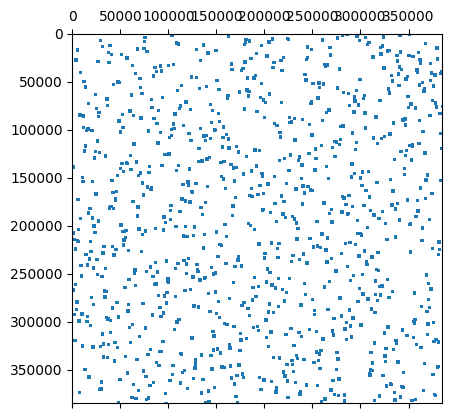

In [92]:
plt.spy(final_matrix,markersize=1)

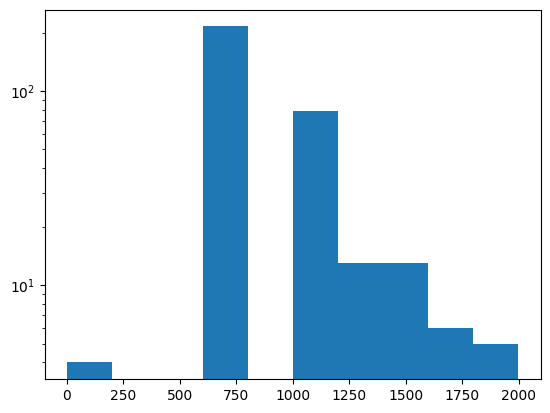

In [93]:
clusters_dict.keys()
lens=[]
for key, ROIs in clusters_dict.items():
    lens.append(len(ROIs))
plt.hist(lens,log=True)   
plt.savefig("roi_cluster_sizes_no_cluster_lim.png")

In [94]:
number_clusters = len(clusters_dict)
total_timestamps = set()
clusters_dict_timestamps = {}
for key, value in clusters_dict.items():
    clusters_dict_timestamps[key] = set()
    for i in value:
        timestamp = i // 400
        clusters_dict_timestamps[key].add(timestamp)
        total_timestamps.add(timestamp)

In [95]:
set_lengths = [len(value) for value in clusters_dict_timestamps.values()]

# Calculate the average and standard deviation
average_length = np.mean(set_lengths)
std_length = np.std(set_lengths)
print(average_length, std_length)

2.4328358208955225 0.6696820496863324


In [96]:
new_label_map, new_inv_map, n_to_c, clusters = find_neurons_with_params(final_matrix, label_map, height_threshold=0, overlap_threshold=2, cluster_lim=True)

In [97]:
clusters_dict = {}
clusters_set = set()
all_values = set(range(len(n_to_c)))
for idx, val in enumerate(n_to_c):
    if idx != val:
        if val not in clusters_dict:
            clusters_dict[val] = [idx, val]
            clusters_set.add(idx)
            clusters_set.add(val)
        else:
            clusters_dict[val].append(idx)
            clusters_set.add(idx)

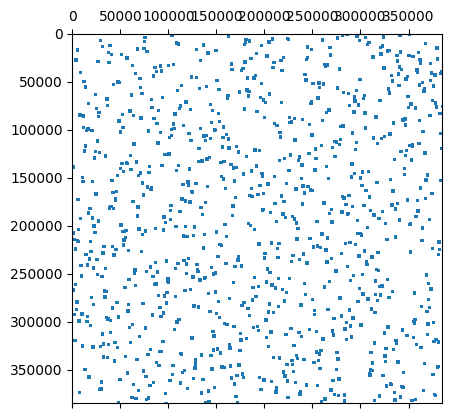

In [98]:
plt.spy(final_matrix,markersize=1)

In [99]:
# sorted=np.argsort(n_to_c)

In [100]:
# B = final_matrix[sorted, :][:, sorted]

In [101]:
# plt.spy(B,markersize=1)

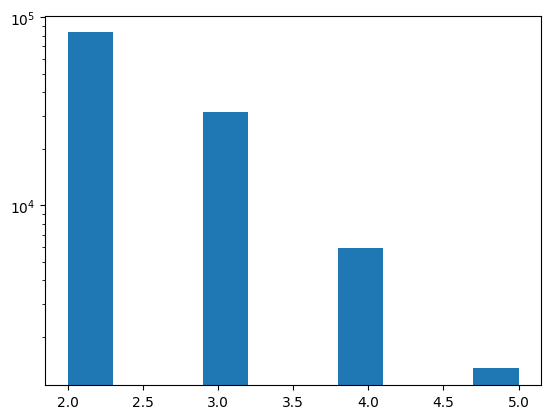

In [102]:
clusters_dict.keys()
lens=[]
for key, ROIs in clusters_dict.items():
    lens.append(len(ROIs))
plt.hist(lens,log=True)   
plt.savefig("roi_cluster_sizes_no_cluster_lim.png")

In [103]:
values_to_remove = all_values - clusters_set
new_label_map_adj = new_label_map 
for value in values_to_remove:
    timestamp = value // 400
    roi = value % 400
    new_label_map_adj[timestamp][roi]=999

In [104]:
number_clusters = len(clusters_dict)
total_timestamps = set()
clusters_dict_timestamps = {}
for key, value in clusters_dict.items():
    clusters_dict_timestamps[key] = set()
    for i in value:
        timestamp = i // 400
        clusters_dict_timestamps[key].add(timestamp)
        total_timestamps.add(timestamp)


In [105]:
set_lengths = [len(value) for value in clusters_dict_timestamps.values()]

# Calculate the average and standard deviation
average_length = np.mean(set_lengths)
std_length = np.std(set_lengths)
print(average_length, std_length)

2.387861580874789 0.6339286860497417


In [106]:
json_path = f'{worm}_label_map_20_999.json'
with open(json_path, 'w') as f:
    json.dump(new_label_map_adj, f, indent=4)

print(f"saved at {json_path}")

saved at sub-20190929-06_label_map_20_999.json


## Applying Clustering

In [107]:
with open(f'{filepath}/{worm}_label_map_20_999.json', 'r') as f:
    dictionary_data = json.load(f)

path=f'/scratch/mie8014/BAN/computer_vision/data/EY/fold1/test/{worm}/moving_rois.h5'
moving=h5py.File(path,'r')

In [ ]:
new_data = np.zeros((len(moving.keys()),256,128, 21))
for prob in tqdm(moving.keys()):
    mov,fixed=prob.split('to')
    t=int(mov)
    data = moving[prob]
    labels=np.unique(data)[1:] #extract actual ROI labels, skip background
    dict= dictionary_data[mov]
    for roi in dict.keys():
        if dict[roi]==999:
            continue
        elif int(roi)<len(labels):
            new_data[t,:,:,:]=np.where(data[:,:,:]==labels[int(roi)],dict[roi]+1,new_data[t,:,:,:]) #dict[roi]+1 to avoid merging with background for 0

 78%|███████▊  | 755/962 [06:59<01:21,  2.55it/s]

In [ ]:
def make_centroids(segmentation, unique_labels):
    centroids=[]

    # unique_labels = np.unique(segmentation)

    for label in unique_labels:
        if label == 0:  # Skip background label
            continue
        
        # Get the indices (coordinates) where the label exists
        coords = np.column_stack(np.where(segmentation == label))
        
        # Compute the centroid by averaging the coordinates
        centroid = np.mean(coords, axis=0)  # axis=0 means average across the (x, y, z) dimensions
        
        # Append the centroid to the list
        centroids.append(centroid)

    # Convert the list of centroids into a numpy array (shape will be 113x3)
    centroids = np.array(centroids)
    return centroids[:400, :]

In [ ]:
unique_labels = np.unique(new_data) # Check how many neurons across timesteps (tomorrow)
final_output = np.zeros((new_data.shape[0], 400, 3))
for timestamp in tqdm(range(new_data.shape[0])):
    centroid = make_centroids(new_data[timestamp, :, :], unique_labels)
    final_output[timestamp, :, :] = centroid

In [ ]:
plt.imshow(new_data[t,:,:,10])

In [ ]:
#save new data (reordered segmentation) as numpy array
np.save(f'{worm}_reordered_seg20_centroids', final_output)
print(f'{worm}_reordered_seg20_centroids')